**This notebook addresses the class imbalance problem present in the dataset. To mitigate this, three resampling techniques are applied: SMOTE, Random Oversampling, and Random Undersampling. The goal is to determine which method best enhances the model's ability to correctly identify both classes.**

In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 66.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer

**Pre-trained DenseNet+SVM with SMOTE**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.8 MB/s eta 0:00:00


In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
import os
os.chdir("/content/drive/MyDrive/brainage_densenet")
print("Current working directory:", os.getcwd())

**Pre-Processing**

In [ ]:
# Load the dataset
dataset = fetch_oasis_vbm(n_subjects=403)
images = dataset.gray_matter_maps
labels = np.where(dataset.ext_vars['cdr'].astype(float) > 0, 1, 0)  # 1: Demented, 0: Non-demented

[fetch_oasis_vbm] Dataset found in /root/nilearn_data/oasis1

In [ ]:
# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)


100%|██████████| 81/81 [00:03<00:00, 26.52it/s]


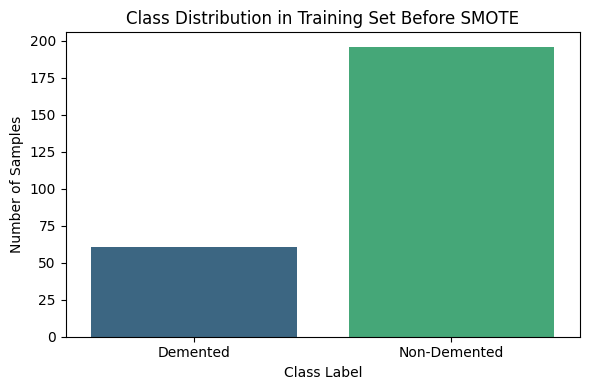

In [ ]:
# Define the output directory in Google Drive
output_dir = "/content/drive/MyDrive/Thesis_Plots_q1"
os.makedirs(output_dir, exist_ok=True)

# Optional mapping for readability
class_names = {0: "Non-Demented", 1: "Demented"}

# Create the bar chart to show the distribution of the data before SMOTE
plot_df_before = pd.DataFrame({"Class": [class_names[c] for c in y_train]})
plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_before, x="Class", hue="Class", palette="viridis", legend=False)
plt.title("Class Distribution in Training Set Before SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_distribution_before_smote.png", dpi=300)
plt.show()
plt.close()

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
oversample = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_flat, y_train)

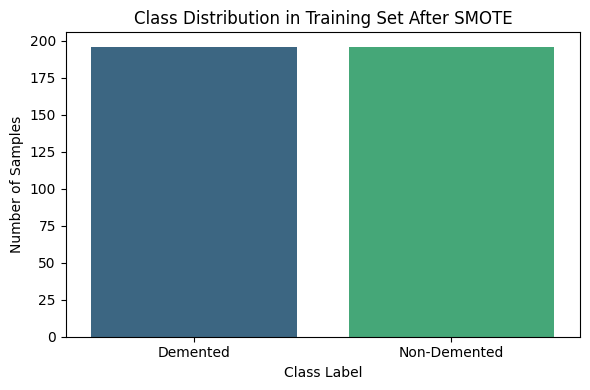

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Check the distribution of the data after SMOTE resampling
plot_df_after = pd.DataFrame({"Class": [class_names[c] for c in y_train_smote]})
plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_after, x="Class", hue="Class", palette="viridis", legend=False)
plt.title("Class Distribution in Training Set After SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_distribution_after_smote.png", dpi=300)
plt.show()
plt.close()

In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

train_dataset = OASISDataset(X_train_smote, y_train_smote)
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)


In [ ]:
# The pre-trained BrainAge_DenseNet is retrived from Hugging Face https://huggingface.co/SisInfLab-AIBio/BrainAge_DenseNet
# Reference paper: De Bonis, M. L. N., Fasano, G., Lombardi, A., Ardito, C., Ferrara, A., Di Sciascio, E., & Di Noia, T. (2024). Explainable brain
# age prediction: a comparative evaluation of morphometric and deep learning pipelines. Brain Informatics, 11(1), 33.

In [ ]:
# The SVM hyperparamters are retrieved from this paper: Givian, H., Calbimonte, J. P., & for the Alzheimer’s Disease Neuroimaging Initiative (2024)
# Early diagnosis of Alzheimer’s disease and mild cognitive impairment using MRI analysis and machine learning algorithms. Discover Applied Sciences, 7(1), 27.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/brainage_densenet')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [01:31<00:00,  4.37s/it]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

# Define the Optuna Objective function and the set of hyperparameters
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])

    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Use F1 score for evaluation
    scores = cross_val_score(model, X_train, y_train_smote, cv=skf, scoring='f1')
    return scores.mean()

In [ ]:
import optuna
import logging
from time import perf_counter

start_tune = perf_counter()

# Run the optimization
study_densenetsvm = optuna.create_study(direction="maximize")
study_densenetsvm.optimize(objective, n_trials=30, n_jobs=1)

end_tune = perf_counter()
tuning_time = end_tune - start_tune
print(f"Hyperparameter‑tuning time: {tuning_time:.2f} s")

# Print the best hyperparameters found
print("Best SVM Params:", study_densenetsvm.best_params)

Hyperparameter‑tuning time: 1029.54 s
Best SVM Params: {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}


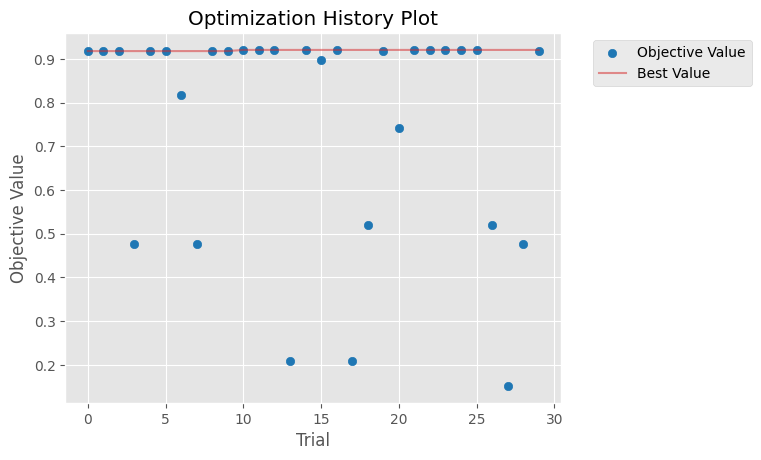

In [ ]:
import warnings
import optuna
import optuna.visualization.matplotlib as vis_matplotlib
import os

# Define the path
save_path = "/content/drive/MyDrive/Thesis_Plots_q1"

# Suppress warnings and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure to the Thesis_Plots_q1 folder
fig = ax.figure
fig.savefig(os.path.join(save_path, "optuna_smote_densenetsvm.png"), dpi=300, bbox_inches='tight')


In [ ]:
smotedensenetsvm_params = study_densenetsvm.best_params
print(smotedensenetsvm_params)

{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}


In [ ]:
final_params_smotedensenetsvm = dict(kernel=smotedensenetsvm_params['kernel'], C= smotedensenetsvm_params['C'], gamma = smotedensenetsvm_params['gamma'])

In [ ]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_smote, y_val], axis=0)

# Define and train the final SVM model using the best hyperparameters
model = SVC(kernel='rbf', C=100, gamma=0.0001, probability=True)

start_train = perf_counter()

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)

end_train = perf_counter()
training_time = end_train - start_train
print(f"Final model training time: {training_time:.2f} s")


Final model training time: 16.09 s


In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    # Convert to NumPy
    y_true  = np.asarray(y_true)
    y_pred  = np.asarray(y_pred)
    y_proba = np.asarray(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the metrics
    accuracy      = accuracy_score(y_true, y_pred)
    balanced_acc  = balanced_accuracy_score(y_true, y_pred)
    precision     = precision_score(y_true, y_pred)
    recall        = recall_score(y_true, y_pred)
    f1            = f1_score(y_true, y_pred)
    logloss       = log_loss(y_true, y_proba)
    brier         = brier_score_loss(y_true, y_proba)
    roc_auc       = roc_auc_score(y_true, y_proba)

    # Print the results
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 score:             {f1:.4f}")
    print(f"Log loss:             {logloss:.4f}")
    print(f"Brier score:          {brier:.4f}")
    print(f"AUC‑ROC:              {roc_auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:

start_test = perf_counter()

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)


end_test = perf_counter()
inference_time = end_test - start_test
print(f"Test‑set inference time: {inference_time:.4f} s")

Test‑set inference time: 0.9843 s


In [ ]:
# Call the function and compute the metrics
test_metrics = evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

Accuracy:             0.7654
Balanced accuracy:    0.6825
Precision:            0.5000
Recall (Sensitivity): 0.5263
F1 score:             0.5128
Log loss:             0.4551
Brier score:          0.1460
AUC‑ROC:              0.8175

Classification report:
              precision    recall  f1-score   support

Non-Demented       0.85      0.84      0.85        62
    Demented       0.50      0.53      0.51        19

    accuracy                           0.77        81
   macro avg       0.68      0.68      0.68        81
weighted avg       0.77      0.77      0.77        81



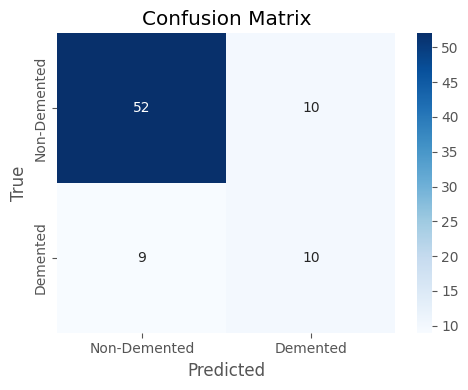

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the directory
save_dir = "/content/drive/My Drive/Thesis_Plots_q1"
filename = "confusion_matrix_smote_densenetsvm.png"

os.makedirs(save_dir, exist_ok=True)

#  Confusion‑matrix plotting function
def confusion_matrix_plot(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return fig

# Plot and save
fig = confusion_matrix_plot(y_test, y_test_pred)
fig.savefig(os.path.join(save_dir, filename), dpi=300)
plt.close(fig)

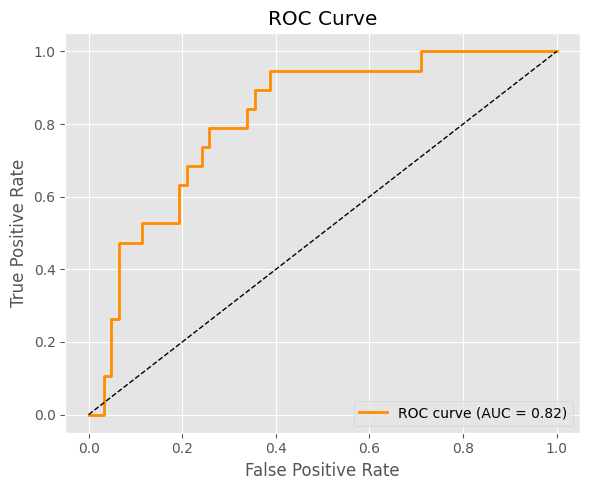

In [ ]:
from sklearn.metrics import roc_curve, auc

# Create the ROC AUC curve
def roc_curve_plot(y_true, y_proba):
    y_proba = np.asarray(y_proba).ravel()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return fig

# Call and save the figure
fig = roc_curve_plot(y_test, y_test_proba)
fig.savefig(os.path.join(save_path, "roc_curve_smote_densenetsvm.png"), dpi=300)
plt.close(fig)

**DenseNet+SVM with Oversampling**

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import imblearn

In [ ]:
# Initial Split
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load Images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

100%|██████████| 81/81 [00:03<00:00, 23.63it/s]


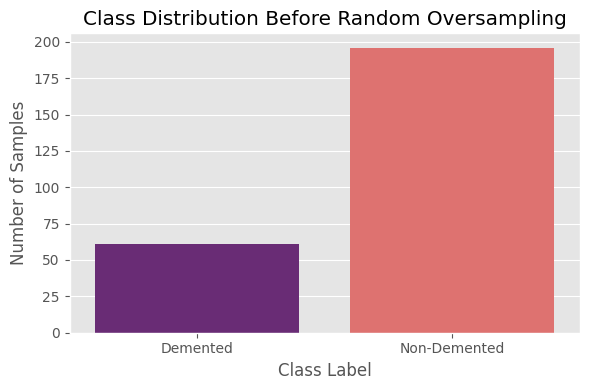

In [ ]:
# Create the bar chart to check the distribution of the data before applying Random Oversampling
plot_df_before_ros = pd.DataFrame({"Class": [class_names[c] for c in y_train]})
plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_before_ros, x="Class", hue="Class", palette="magma", legend=False)
plt.title("Class Distribution Before Random Oversampling")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_before_ros.png", dpi=300)
plt.show()
plt.close()

In [ ]:
# Apply Random Oversampling to the minority class on the training set
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train_flat, y_train)

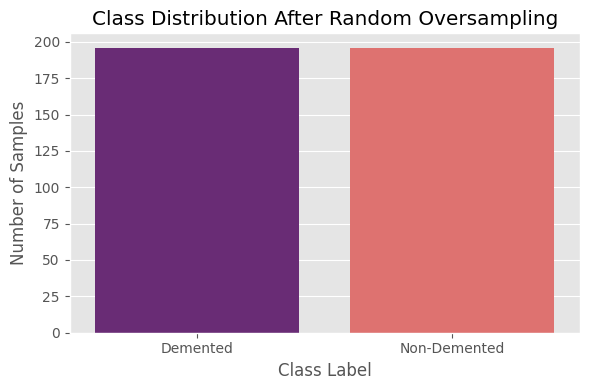

In [ ]:
# Distribution after Oversampling
plot_df_after_ros = pd.DataFrame({"Class": [class_names[c] for c in y_train_over]})
plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_after_ros, x="Class", hue="Class", palette="magma", legend=False)
plt.title("Class Distribution After Random Oversampling")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_after_ros.png", dpi=300)
plt.show()
plt.close()

In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)
        return img_tensor, self.labels[idx]

# Use Random Oversampled training data
train_dataset = OASISDataset(X_train_over, y_train_over)

# Validation and test sets remain unchanged
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)

In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [01:44<00:00,  4.98s/it]


In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_over), y=y_train_over)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

# Define the Optuna Objective function and the set of hyperparameters
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])

    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight=class_weights_dict)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Use F1 score for evaluation
    scores = cross_val_score(model, X_train, y_train_over, cv=skf, scoring='f1')       # X_train: DenseNet features extracted from X_train_over; y_train_over: labels from RandomOverSampler
    return scores.mean()


In [ ]:
import optuna
import logging
from time import perf_counter

start_tune = perf_counter()

# Run the optimization
study_densenetsvm_over = optuna.create_study(direction="maximize")
study_densenetsvm_over.optimize(objective, n_trials=30, n_jobs=1)

end_tune = perf_counter()
tuning_time = end_tune - start_tune
print(f"Hyperparameter‑tuning time: {tuning_time:.2f} s")

print("Best SVM Params:", study_densenetsvm_over.best_params)

Best SVM Params: {'kernel': 'rbf', 'C': 100, 'gamma': 10}


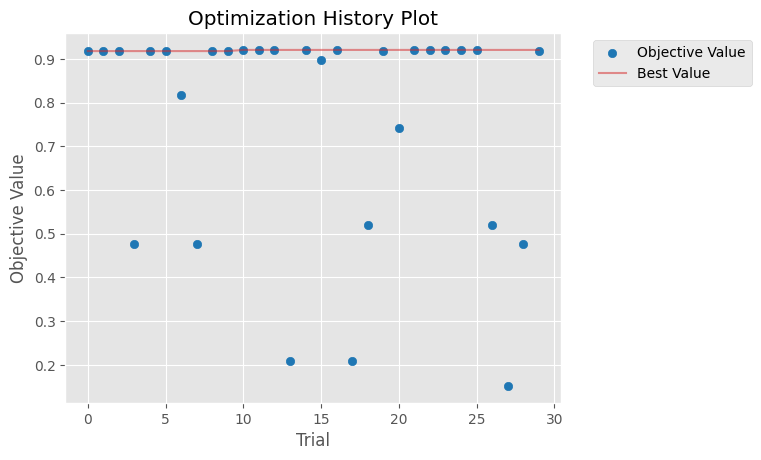

In [ ]:
import warnings
import optuna
import optuna.visualization.matplotlib as vis_matplotlib
import os

# Define the path
save_path = "/content/drive/MyDrive/Thesis_Plots_q1"

# Suppress warnings and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure to the Thesis_Plots_q1 folder
fig = ax.figure
fig.savefig(os.path.join(save_path, "optuna_over_densenetsvm.png"), dpi=300, bbox_inches='tight')

In [ ]:
over_densenetsvm_params = study_densenetsvm.best_params
print(over_densenetsvm_params)

{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}


In [ ]:
final_params_over_densenetsvm = dict(kernel=over_densenetsvm_params['kernel'], C= over_densenetsvm_params['C'], gamma = over_densenetsvm_params['gamma'])

In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_over), y=y_train_over)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_over, y_val], axis=0)

# Define the final SVM model using the best hyperparameters
model = SVC(kernel='rbf', C=100, gamma=0.0001, probability=True, class_weight=class_weights_dict)

start_train = perf_counter()

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)

end_train = perf_counter()
training_time = end_train - start_train
print(f"Final model training time: {training_time:.2f} s")



Final model training time: 12.30 s


In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    # Convert to NumPy
    y_true  = np.asarray(y_true)
    y_pred  = np.asarray(y_pred)
    y_proba = np.asarray(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the metrics
    accuracy      = accuracy_score(y_true, y_pred)
    balanced_acc  = balanced_accuracy_score(y_true, y_pred)
    precision     = precision_score(y_true, y_pred)
    recall        = recall_score(y_true, y_pred)
    f1            = f1_score(y_true, y_pred)
    logloss       = log_loss(y_true, y_proba)
    brier         = brier_score_loss(y_true, y_proba)
    roc_auc       = roc_auc_score(y_true, y_proba)

    # Print the results
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 score:             {f1:.4f}")
    print(f"Log loss:             {logloss:.4f}")
    print(f"Brier score:          {brier:.4f}")
    print(f"AUC‑ROC:              {roc_auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
start_test = perf_counter()

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)


end_test = perf_counter()
inference_time = end_test - start_test
print(f"Test‑set inference time: {inference_time:.4f} s")


Test‑set inference time: 0.8138 s


In [ ]:
# Call the function and compute the metrics
test_metrics = evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

Accuracy:             0.7654
Balanced accuracy:    0.6643
Precision:            0.5000
Recall (Sensitivity): 0.4737
F1 score:             0.4865
Log loss:             0.4768
Brier score:          0.1506
AUC‑ROC:              0.8251

Classification report:
              precision    recall  f1-score   support

Non-Demented       0.84      0.85      0.85        62
    Demented       0.50      0.47      0.49        19

    accuracy                           0.77        81
   macro avg       0.67      0.66      0.67        81
weighted avg       0.76      0.77      0.76        81



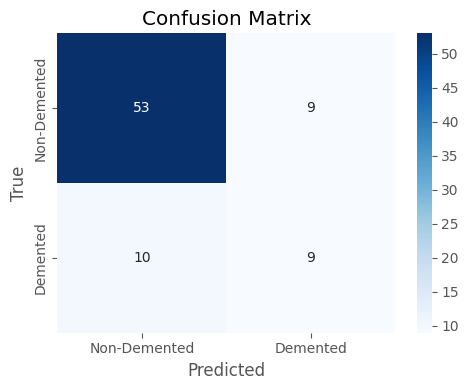

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix plotting function
def confusion_matrix_plot(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return fig

# Plot and save
fig = confusion_matrix_plot(y_test, y_test_pred)
fig.savefig(os.path.join(save_dir, filename), dpi=300)
plt.close(fig)

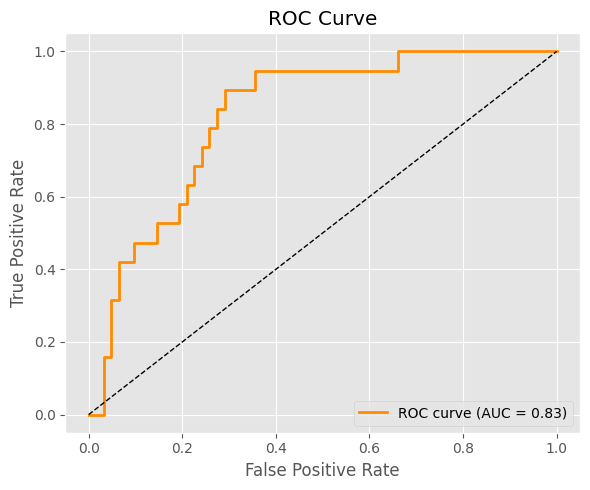

In [ ]:
from sklearn.metrics import roc_curve, auc

# Create the ROC AUC curve plot
def roc_curve_plot(y_true, y_proba):
    y_proba = np.asarray(y_proba).ravel()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, color='darkorange',
             label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return fig

# Call and save the figure
fig = roc_curve_plot(y_test, y_test_proba)
fig.savefig(os.path.join(save_path, "roc_curve_over_densenetsvm.png"), dpi=300)
plt.close(fig)

**DenseNet+SVM with Undersampling**

In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Initial Split
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load Images as flattened vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-score normalization using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

100%|██████████| 81/81 [00:02<00:00, 30.31it/s]


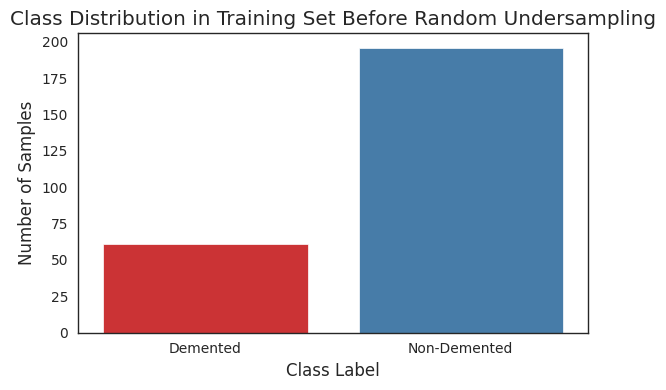

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Optional mapping for readability
class_names = {0: "Non-Demented", 1: "Demented"}

# Set consistent white background style
sns.set_style("white")

# Check the distribution of the data before undersampling
plot_df_before = pd.DataFrame({"Class": [class_names[c] for c in y_train]})
plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_before, x="Class", hue="Class", palette="Set1", legend=False)
plt.title("Class Distribution in Training Set Before Random Undersampling")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_before_under.png", dpi=300)
plt.show()
plt.close()


In [ ]:
# Apply Random Undersampling to the majority class on the training set
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_flat, y_train)


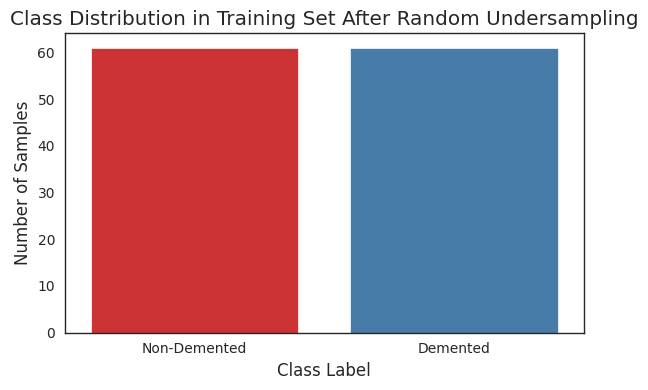

In [ ]:
# Distribution of the data after Undersampling
plot_df_after = pd.DataFrame({"Class": [class_names[c] for c in y_train_under]})

plt.figure(figsize=(6, 4))
sns.countplot(data=plot_df_after, x="Class", hue="Class", palette="Set1", legend=False)
plt.title("Class Distribution in Training Set After Random Undersampling")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig(f"{output_dir}/class_after_under.png", dpi=300)
plt.show()
plt.close()

In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)
        return img_tensor, self.labels[idx]

# Use Random Undersampled training data for training dataset
train_dataset = OASISDataset(X_train_under, y_train_under)

# Validation and test sets remain unchanged
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)

In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


In [ ]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

# Define the Optuna Objective function and the set of hyperparameters
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])

    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Use F1 score for evaluation
    scores = cross_val_score(model, X_train, y_train_under, cv=skf, scoring='f1')
    return scores.mean()

In [ ]:
import optuna
import logging
from time import perf_counter

start_tune = perf_counter(0)

# Run the optimization
study_densenetsvm_under = optuna.create_study(direction="maximize")
study_densenetsvm_under.optimize(objective, n_trials=30, n_jobs=1)

end_tune = perf_counter()
tuning_time = end_tune - start_tune
print(f"Hyperparameter‑tuning time: {tuning_time:.2f} s")

print("Best SVM Params:", study_densenetsvm_under.best_params)

Best SVM Params: {'kernel': 'poly', 'C': 0.01, 'gamma': 0.001}


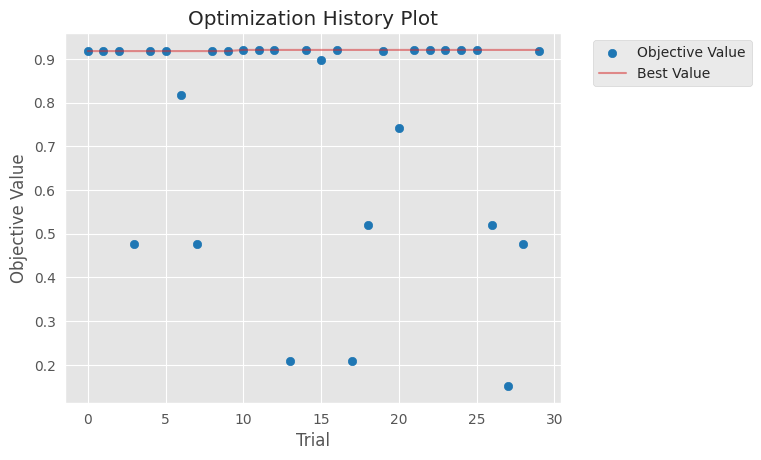

In [ ]:
import warnings
import optuna
import optuna.visualization.matplotlib as vis_matplotlib
import os

# Define the desired save path
save_path = "/content/drive/MyDrive/Thesis_Plots_q1"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Suppress warnings and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure to the thesis plots
fig = ax.figure
fig.savefig(os.path.join(save_path, "optuna_under_densenetsvm.png"), dpi=300, bbox_inches='tight')

In [ ]:
under_densenetsvm_params = study_densenetsvm.best_params
print(under_densenetsvm_params)

{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}


In [ ]:
final_params_under_densenetsvm = dict(kernel=under_densenetsvm_params['kernel'], C= under_densenetsvm_params['C'], gamma = under_densenetsvm_params['gamma'])

In [ ]:
# Combine train and val sets
X_trainval_final = np.concatenate([X_train, X_val], axis=0)
y_trainval_final = np.concatenate([y_train_under, y_val], axis=0)

# Define the final SVM model using the best hyperparameters
model = SVC(kernel='rbf', C=100, gamma=0.0001, probability=True)

start_train = perf_counter()

# Train the algorithm on combined train+val set
model.fit(X_trainval_final, y_trainval_final)

end_train = perf_counter()
training_time = end_train - start_train
print(f"Final model training time: {training_time:.2f} s")


Final model training time: 1.38 s


In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    # Convert to NumPy
    y_true  = np.asarray(y_true)
    y_pred  = np.asarray(y_pred)
    y_proba = np.asarray(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the metrics
    accuracy      = accuracy_score(y_true, y_pred)
    balanced_acc  = balanced_accuracy_score(y_true, y_pred)
    precision     = precision_score(y_true, y_pred)
    recall        = recall_score(y_true, y_pred)
    f1            = f1_score(y_true, y_pred)
    logloss       = log_loss(y_true, y_proba)
    brier         = brier_score_loss(y_true, y_proba)
    roc_auc       = roc_auc_score(y_true, y_proba)

    # Print the results
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 score:             {f1:.4f}")
    print(f"Log loss:             {logloss:.4f}")
    print(f"Brier score:          {brier:.4f}")
    print(f"AUC‑ROC:              {roc_auc:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
start_test = perf_counter()

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Demented)

end_test = perf_counter()
inference_time = end_test - start_test
print(f"Test‑set inference time: {inference_time:.4f} s")

Test‑set inference time: 0.5056 s


In [ ]:
# Call the function and compute the metrics
test_metrics = evaluate_model(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba, class_names=['Non-Demented', 'Demented'])

Accuracy:             0.7037
Balanced accuracy:    0.7152
Precision:            0.4242
Recall (Sensitivity): 0.7368
F1 score:             0.5385
Log loss:             0.4971
Brier score:          0.1667
AUC‑ROC:              0.8311

Classification report:
              precision    recall  f1-score   support

Non-Demented       0.90      0.69      0.78        62
    Demented       0.42      0.74      0.54        19

    accuracy                           0.70        81
   macro avg       0.66      0.72      0.66        81
weighted avg       0.79      0.70      0.72        81



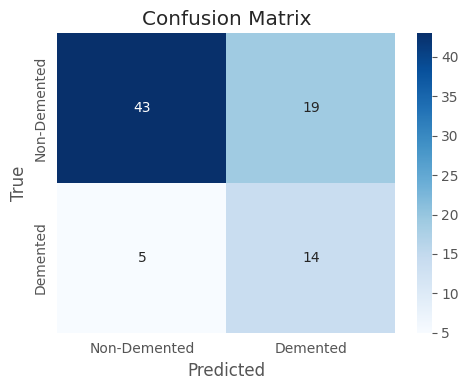

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the directory
save_dir = "/content/drive/My Drive/Thesis_Plots_q1"
filename = "conf_matrix_under_densenetsvm.png"

os.makedirs(save_dir, exist_ok=True)

#  Confusion‑matrix plotting function
def confusion_matrix_plot(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = ['Non‑Demented', 'Demented']

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return fig

# Plot and save
fig = confusion_matrix_plot(y_test, y_test_pred)
fig.savefig(os.path.join(save_dir, filename), dpi=300)
plt.close(fig)

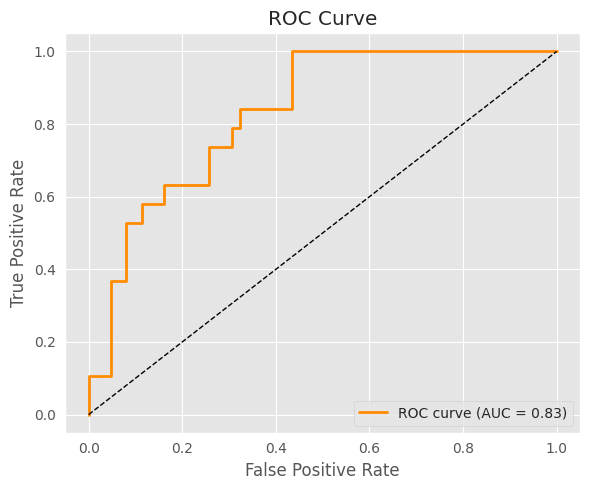

In [ ]:
from sklearn.metrics import roc_curve, auc

# Create the ROC AUC curve plot
def roc_curve_plot(y_true, y_proba):
    y_proba = np.asarray(y_proba).ravel()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, color='darkorange',
             label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return fig

# Call and save the figure
fig = roc_curve_plot(y_test, y_test_proba)
fig.savefig(os.path.join(save_path, "roc_curve_under_densenetsvm.png"), dpi=300)
plt.close(fig)

**Model comparison**

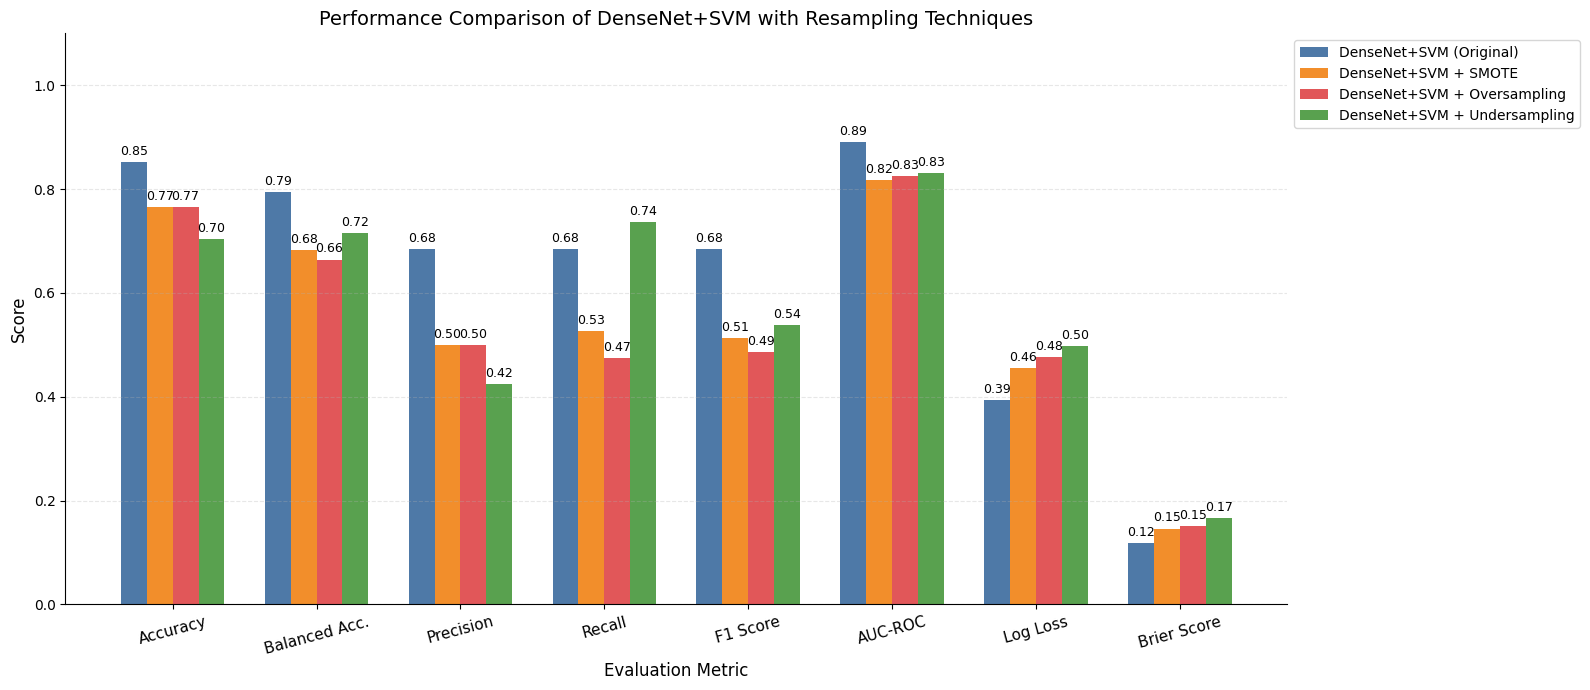

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Output path
output_dir = "/content/drive/MyDrive/Thesis_Plots_q1"
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, "resampling_comparison_all_metrics.png")

# Model names
models = ['DenseNet+SVM (Original)', 'DenseNet+SVM + SMOTE', 'DenseNet+SVM + Oversampling', 'DenseNet+SVM + Undersampling']

# Metrics for each model
accuracy         = [0.8519, 0.7654, 0.7654, 0.7037]
balanced_accuracy= [0.7937, 0.6825, 0.6643, 0.7152]
precision        = [0.6842, 0.5000, 0.5000, 0.4242]
recall           = [0.6842, 0.5263, 0.4737, 0.7368]
f1               = [0.6842, 0.5128, 0.4865, 0.5385]
auc              = [0.8913, 0.8175, 0.8251, 0.8311]
log_loss         = [0.3932, 0.4551, 0.4768, 0.4971]
brier_score      = [0.1185, 0.1460, 0.1506, 0.1667]

# Combine metrics
metric_names = ['Accuracy', 'Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Log Loss', 'Brier Score']
metrics = np.array([accuracy, balanced_accuracy, precision, recall, f1, auc, log_loss, brier_score])

# Plotting
x = np.arange(len(metric_names))
bar_width = 0.18
colors = ['#4E79A7', '#F28E2B', '#E15759', '#59A14F']

fig, ax = plt.subplots(figsize=(16, 7))
for i in range(len(models)):
    bars = ax.bar(x + i * bar_width, metrics[:, i], width=bar_width, label=models[i], color=colors[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Styling
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_title('Performance Comparison of DenseNet+SVM with Resampling Techniques', fontsize=14)
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(metric_names, fontsize=11, rotation=15)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_facecolor('white')
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save to Drive
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
